## IBSI Chapter 1 Phase 2 − Radiomic Computations

@Author : [MEDomics consortium](https://github.com/medomics/)

@EMAIL : medomics.info@gmail.com

@REF : [IBSI 1](https://arxiv.org/pdf/1612.07003.pdf)

**STATEMENT**:
This file is part of <https://github.com/MEDomics/MEDomicsLab/>,
a package providing PYTHON programming tools for radiomics analysis.
--> Copyright (C) MEDomicsLab consortium.

This package is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This package is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this package.  If not, see <http://www.gnu.org/licenses/>.

### Introduction


In this notebook we treat the second phase of standardization of image processing and feature computation. In the figure below, we focus on the second part, phase 2. So we only compute radiomics features from a CT image after specific processing

<img src="https://www.researchgate.net/profile/Emiliano-Spezi/publication/339835844/figure/fig1/AS:867857227337731@1583924695905/Flowchart-of-study-overview-The-workflow-in-a-typical-radiomics-analysis-starts-with.ppm" alt="Flowchart of radiomics study" style="width:500px;"/>


### Dataset - CT image
In this chapter and in this phase, reference values for features were obtained using a CT image, which is described below. The CT image can be found here: [IBSI 1 CT Phantom](https://github.com/theibsi/data_sets/tree/master/ibsi_1_ct_radiomics_phantom)

The CT image set is stored as a stack of slices in DICOM format. The gross tumour volume (GTV) was delineated and is used as the region of interest (ROI). Contour information is stored as an RT structure set in the DICOM
file starting with DCM RS. For broader use, both the DICOM set and segmentation mask have been
converted to the NIfTI format. When using the data in NIfTI format, both image stacks should
be converted to (at least) 32-bit floating point and rounded to the nearest integer before further
processing.

In [ ]:
import argparse
import os
import pickle
import sys
from copy import deepcopy
from itertools import product
from json import dump, dumps
from pathlib import Path

MODULE_DIR = os.path.dirname(os.path.abspath('../MEDimage/MEDimage.py'))
sys.path.append(os.path.dirname(MODULE_DIR))

import numpy as np
from MEDimage.MEDimage import MEDimage
from MEDimage.MEDimageComputeRadiomics import MEDimageComputeRadiomics
from MEDimage.MEDimageProcessing import MEDimageProcessing
from MEDimage.utils import jsonUtils
from numpyencoder import NumpyEncoder

In [ ]:
from MEDimage.processing.getROI_fromIndexes import getROI_fromIndexes
from MEDimage.processing.roiExtract import roiExtract

In [ ]:
def __getPathResults():
    _rp = Path(os.getcwd()) / "results/ibsi1/phase2"
    if not _rp.exists():
        Path.mkdir(_rp, parents=True)
    return _rp

### Configuration

Most important part of the code is to chose what configuration is used for image processing. The figure below shows the different configurations possible: 

*A, B, C ,D and E*.

In [ ]:
CONFIG = 'E' # script configuration. Possible values : 'A', 'B', 'C', 'D', 'E'

<img src="https://github.com/MahdiAll99/MEDimage/blob/main/IBSI-TESTs/images/ibsi1-p1-configs.png?raw=true" alt="Flowchart of radiomics study"/>

Refer to the [IBSI 1 Reference chapter 5](https://arxiv.org/pdf/1612.07003.pdf#chapter.5) for more details.
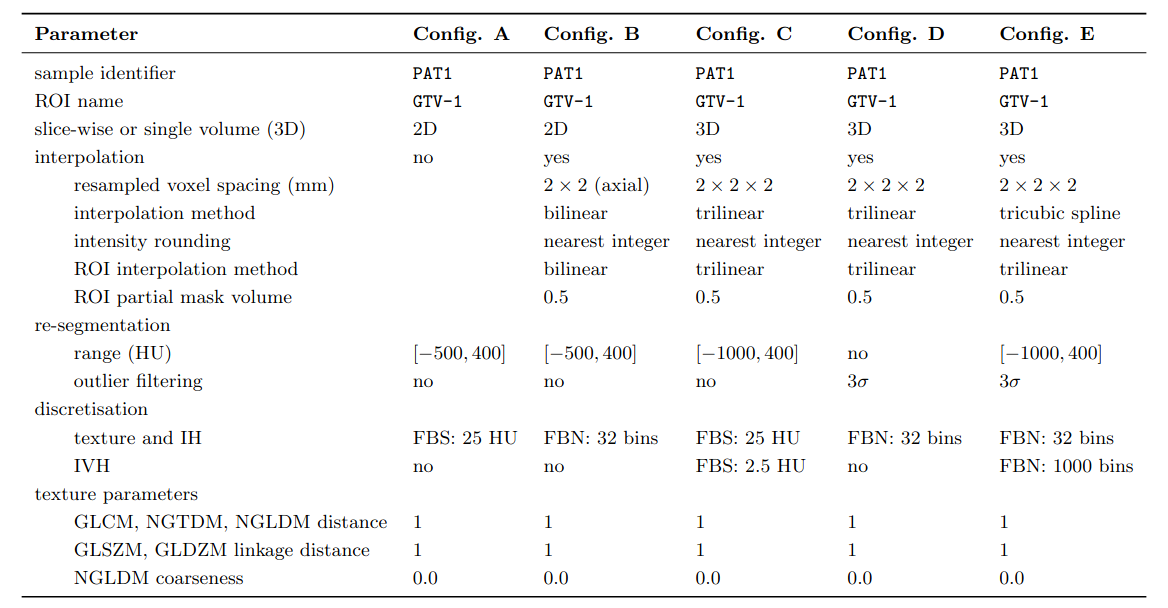

We start by initializing the important paths to settings folder, dataset folder...

In [ ]:
pathData = Path(os.getcwd()) / "data" # Path to the data folder
pathSettings = Path(os.getcwd()) / "settings" # Path to the script settings/configuration folder

File naming should respect the following conventions : 
- NPY format : **PatientID__ImagingScanName.ImagingModality.npy**
- NIfTI format : **PatientID__ImagingScanName(tumorAuto).ImagingModality.nii.gz**

The following settings are untochable (Set by the IBSI):

In [ ]:
nameRead = 'PAT1__CT(tumorAuto).CTscan.nii.gz' # Path to the CT-image
pathRead = pathData / 'CTimage' # CT image folder name
nameROI = '{GTV-1}' # Region of interest name
roiType = ''
roiType_label = ''

In [ ]:
def init_MEDimage(imParams):
    """
    Initializes the MEDimage class and the child classes.
    :param imParams : Dict of the test parameters.
    :return: Child classes (MEDimageProcessing and MEDimageComputeRadiomics).
    """ 
    if nameRead.endswith('.npy'):
        # MEDimage instance is now in Workspace
        with open(pathRead / nameRead, 'rb') as f: MEDimg = pickle.load(f)

        # MEDimageProcess instance is now in Workspace
        MEDimageProcess = MEDimageProcessing(MEDimg=MEDimg, log_file=pathRead /'log_file_ibsi1p2.txt')

        # MEDimageComputeRadiomics instance is now in Workspace
        MEDimageCR = MEDimageComputeRadiomics(MEDimg=MEDimg, log_file=MEDimageProcess.log_file)

        # Initialize processing & computation parameters
        MEDimageProcess.init_Params(imParamScan=imParams,
                                    imParamFilter=imParams['imParamFilter'],
                                    roiType=roiType)

        # Clear MEDimage instance # Clear up RAM
        MEDimg = None 

        return MEDimageProcess, MEDimageCR

    # Set up NIFTI Image path 
    NiftiImage = pathRead / nameRead

    # MEDimage instance is now in Workspace
    MEDimg = MEDimage()

    # Initialization using NIFTI file :
    MEDimg.init_from_nifti(NiftiImagePath=NiftiImage)

    # spatialRef Creation : 
    MEDimg.scan.volume.spatialRef_from_NIFTI(NiftiImage)

    # MEDimageProcess instance is now in Workspace
    MEDimageProcess = MEDimageProcessing(MEDimg=MEDimg, log_file=pathRead /'log_file_ibsi1p2.txt')

    # MEDimageComputeRadiomics instance is now in Workspace
    MEDimageCR = MEDimageComputeRadiomics(MEDimg=MEDimg, log_file=MEDimageProcess.log_file)

    # Initialize processing & computation parameters
    MEDimageProcess.init_Params(imParamScan=imParams,
                                imParamFilter=imParams['imParamFilter'],
                                roiType=roiType)

    # Clear MEDimage instance, clear up RAM
    MEDimg = None

    return MEDimageProcess, MEDimageCR

In [ ]:
def get_imParams(CONFIG):
    """
    Loads the corresponding configuration to run the script.
    :param CONFIG: Configuration ID used in the script (Test ID).
    :return: dict of the script configuration.
    """
    # Config A:
    if CONFIG == 'A':
        imParams = jsonUtils.loadjson(pathSettings / 'Phase2A_settings.json')

    # Config B:
    elif CONFIG == 'B':
        imParams = jsonUtils.loadjson(pathSettings / 'Phase2B_settings.json')

    # Config C:
    elif CONFIG == 'C':
        imParams = jsonUtils.loadjson(pathSettings / 'Phase2C_settings.json')

    # Config D:
    elif CONFIG == 'D':
        imParams = jsonUtils.loadjson(pathSettings / 'Phase2D_settings.json')

    # Config E:
    elif CONFIG == 'E':
        imParams = jsonUtils.loadjson(pathSettings / 'Phase2E_settings.json')

    else:
        raise ValueError(r"CONFIG must be 'A', 'B', 'C', 'D' or 'E'")

    return imParams

In [ ]:
def save_results(MEDimageCR, config, pathResults):
    """
    Saves the results in a JSON file under the name : Results_P1.json
    :param MEDimageCR: Instance of MEDImageComputeRadiomics class.
    :param config: Configuration ID used in the script (Test ID).
    :return: None.
    """
    with open(pathResults / f"Results_P2{config}.json", "w") as fp:   
        dump(MEDimageCR.Params['radiomics']['image'], fp, indent=4, cls=NumpyEncoder)

### Classes initialization

Before the initialization we need to extract the right parameters/configurations for the script

In [ ]:
imParams = get_imParams(CONFIG)

In the IBSI scripts we are going to use the **MEDimage** class and its childs (**MEDimageProcessing** and **MEDimageComputeRadiomics**) to process the images and to extract the features. So the first step is to initialize the MEDimage class either using a **NIFTI** or a **NPY** file. The npy format already contains a MEDimage instance, for the NIfTI format make sure the mask file is in the same folder with the correct name.


In [ ]:
MEDimageProcess, MEDimageCR = init_MEDimage(imParams) 

### Image processing
Unlike phase 1, processing is required here and different configurations can be tested as mentionned in the IBSI chapter 1. The processing steps are:
- **Segmentation (Creation of ROI mask)**
- **Interpolation**
- **Re-segmentation**
- **ROI extraction**
- **Intensity discretization (for some family features)**

**PS**: MEDomicsLab framework only supports 3D interpolation. The IBSI features computation for 2D configurations cannot be done.

#### Segmentation

ROIs are used to define the region in which features are calculated. What constitutes an ROI depends on the imaging and the study objective. In medical imaging of cancer patients, the tumour volume is a common ROI. ROIs can be defined manually by experts or (semi-)automatically using algorithms. ROIs are typically stored with the accompanying image (which is the case here).

First, we create the ROI mask

In [ ]:
volObjInit, roiObjInit = getROI_fromIndexes(MEDimageProcess, nameROI=nameROI, boxString='full')

We extract the initial diagnostic features, so we can identify if there is any issues with the implementation before image processing.

In [ ]:
from MEDimage.processing.getDiagFeatures import getDiagFeatures

# intial diagnostic features extraction:
DIAG_initial = getDiagFeatures(volObjInit, roiObjInit, roiObjInit, 'initial')
# Update diagnostic Dict:
MEDimageCR.Params['radiomics']['image'].update(
    {'Diagnostics-initial': 
        {'scale' + str(MEDimageCR.Params['scaleNonText'][0]): DIAG_initial}
    })

#### Interpolation

Texture feature sets require interpolation to isotropic voxel spacing to be rotationally invariant, and to allow comparison between image data from different samples, cohorts or batches. Interpolation algorithms translate image intensities from the original image grid to an interpolation grid. 

The figure below shows different interpolation mesh grids based on an original 4 × 4 grid with (3.00, 3.00) mm spacing. The desired interpolation spacing is (2.00, 2.00) mm. *Fit to original grid* creates an interpolation mesh grid that overlaps with the corners of the original grid. *Align grid* origins creates an interpolation mesh grid that is positioned at the origin of the original grid. *Align grid centers* creates an interpolation grid that is centered on the center of original and interpolation grids

<img src="https://github.com/MahdiAll99/MEDimage/blob/main/IBSI-TESTs/images/interpolation-ex.png?raw=true" alt="Flowchart of radiomics study"/>
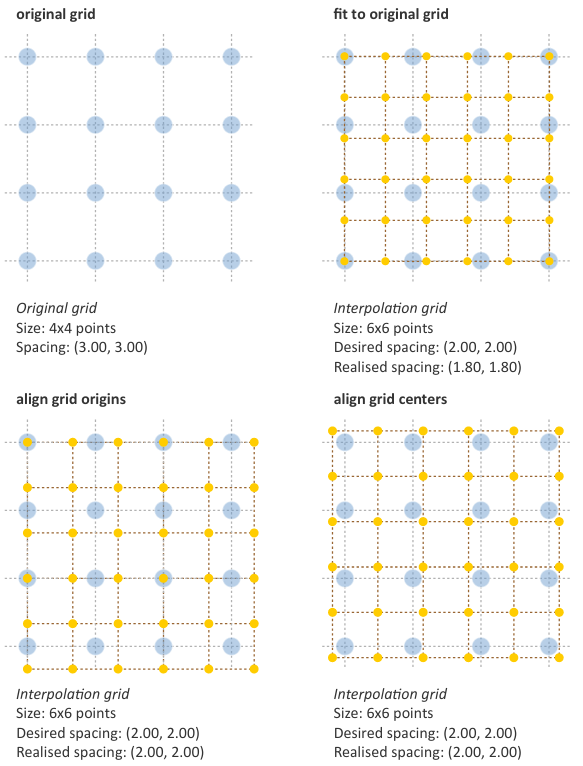

We interpolate both volume data and ROI data in order to create the morphological and the intensity masks:

   - **The morphological mask**: is not re-segmented and maintains the original morphology as defined by an expert and/or (semi-)automatic segmentation algorithms.
   - **The intensity mask**: can be re-segmented and will contain only the selected voxels. For many feature families, only this is important. 

**PS** : Interpolation is not required for the configuration A.

In [ ]:
from MEDimage.processing.interpVolume import interpVolume

volObj = deepcopy(volObjInit)
roiObj_Morph = deepcopy(roiObjInit)

if CONFIG != 'A':
    # Intensity Mask:
    volObj = interpVolume(
        MEDimageCR,
        volObjS=volObjInit,
        voxDim=MEDimageCR.Params['scaleNonText'],
        interpMet=MEDimageCR.Params['volInterp'],
        roundVal=MEDimageCR.Params['glRound'],
        image_type='image',
        roiObjS=roiObjInit,
        boxString='full'
    )
    # Morphological Mask:
    roiObj_Morph = interpVolume(
        MEDimageCR,
        volObjS=roiObjInit,
        voxDim=MEDimageCR.Params['scaleNonText'],
        interpMet=MEDimageCR.Params['roiInterp'],
        roundVal=MEDimageCR.Params['roiPV'], 
        image_type='roi', 
        roiObjS=roiObjInit,
        boxString='full'
    )

We can see how the voxel spacing can change before interpolation and after interpolation (If config is different than A)

In [ ]:
# Desired voxel spacing
print(f'Desired spacing (Config {CONFIG}):', 
      imParams['image']['interp']['scaleNonText'])

# voxel spacing before interpolation
print('Before interp:', [volObjInit.spatialRef.PixelExtentInWorldX, 
      volObjInit.spatialRef.PixelExtentInWorldY,
      volObjInit.spatialRef.PixelExtentInWorldZ])

# voxel spacing after interpolation
print('After interp:',[volObj.spatialRef.PixelExtentInWorldX, 
      volObj.spatialRef.PixelExtentInWorldY,
      volObj.spatialRef.PixelExtentInWorldZ])

Post-interpolation diagnostic features computation

In [ ]:
# Post-interpolation diagnostic features extraction:
DIAG_interp = getDiagFeatures(volObj, roiObj_Morph, roiObj_Morph, 'interp')

# Update diagnostic Dict:
MEDimageCR.Params['radiomics']['image'].update(
    {'Diagnostics-interpolated': 
        {'scale' + str(MEDimageCR.Params['scaleNonText'][0]): DIAG_interp}
    })

#### Re-segmentation

Next processing step is re-segmentation, we update the ROI mask based on corresponding configuration given voxel intensities (For example exclusion of air or bone voxels from a defined ROI on CT image). 

- **range re-segmentation**

Range re-segmentation will remove voxels from the intensity mask that fall outside of a specified range. 

The figure below shows how intensity and morphological masks change with re-segmentation. (1) The original region of interest (ROI) is shown with pixel intensities. (2) Subsequently, the ROI is re-segmented to only contain values in the range [1, 6]. Pixels outside this range
are marked for removal from the intensity mask. (3a) Resulting morphological mask, which is identical
to the original ROI. (3b) Re-segmented intensity mask.

<img src="https://www.researchgate.net/profile/Alex-Zwanenburg/publication/311805734/figure/fig3/AS:867063404961792@1583735433260/Example-showing-how-intensity-and-morphological-masks-may-differ-due-to-resegmentation.png" alt="range resegmentation example" style="width:500px;"/>

In [ ]:
from MEDimage.processing.rangeReSeg import rangeReSeg

roiObj_Int = deepcopy(roiObj_Morph)
roiObj_Int.data = rangeReSeg(vol=volObj.data, 
                             roi=roiObj_Int.data,
                             im_range=MEDimageCR.Params['im_range'])

- **outlier re-segmentation**

ROI voxels with outlier intensities are removed from the intensity mask.

The figure below shows a re-segmentation example based on a CT-image. The masked region (blue) is re-
segmented to create an intensity mask (orange). Examples using three different re-segmentation parameter sets are shown. The bottom right combines the range and outlier re-segmentation, and the
resulting mask is the intersection of the masks in the other two examples

<img src="https://ibsi.readthedocs.io/en/latest/_images/resegmentation.png" alt=" outlier resegmentation example" style="width:500px;"/>

In [ ]:
from MEDimage.processing.outlierReSeg import outlierReSeg

# re-compute the range (externally) for comparison
u = np.mean(volObj.data[roiObj_Int.data == 1])
sigma = np.std(volObj.data[roiObj_Int.data == 1])

outlierRange = [u + 3*sigma, u - 3*sigma]

roiObj_Int.data = np.logical_and(
    outlierReSeg(vol=volObj.data, roi=roiObj_Int.data, outliers=MEDimageCR.Params['outliers']),
    roiObj_Int.data
).astype(int)

Post-re-segmentation diagnostic features computation

In [ ]:
# Post-resegmentation diagnostic features extraction:
DIAG_reSeg = getDiagFeatures(volObj, roiObj_Int, roiObj_Morph, 'reSeg')

# Update diagnostic Dict:
MEDimageCR.Params['radiomics']['image'].update({'Diagnostics-resegmented': 
                            {'scale' + str(MEDimageCR.Params['scaleNonText'][0]): DIAG_reSeg}
                            })

#### ROI extraction

After re-segmentation, we extract the image volume that will be studied that is defined by the ROI intensity mask. Excluded voxels (Intensities outside ROI) will be replaced by *NaN* and voxels included in the ROI mask retain their original intensity as shows the figure below.

<img src="https://ibsi.readthedocs.io/en/latest/_images/roi_extraction.png" alt=" ROI extraction example" style="width:500px;"/>


In [ ]:
volInt_RE = roiExtract(
    vol=volObj.data, 
    roi=roiObj_Int.data
)

We can check the change of intensity range before and after re-segmentation. The max and min should respect the re-segmentation range defined in the settings and the outlier range defined by the outlier re-seg algorithm. For example : in configuration A, the re-segmentation range is [-500, 400] so the intensities min and the intensities max should not be lower or higher than -500 and 400 respectively

In [ ]:
# Desired re-segmentation range
print(f'Desired re-segmentation range (Config {CONFIG}):', 
      imParams['image']['reSeg']['range'])

print(f'Desired re-segmentation outlier range (Config {CONFIG}):', 
      outlierRange)

# Intensity range before re-segmentation
print(f'Intensity range before, min:{np.min(volObjInit.data)} max:{np.max(volObjInit.data)}')

# Intensity range after re-segmentation
print(f'Intensity range after, min:{np.nanmin(volInt_RE)} max:{np.nanmax(volInt_RE)}')

Initialization of all the computation parameters for NON-TEXTURE FEATURES as well as the results dict.

In [ ]:
# Preparation of computation :
MEDimageCR.init_NTF_Calculation(volObj)

### Non-Texture Features extraction
In this section we extract the following families of features using MEDimageComputeRadiomics methods : 

*morphological features, local intensity, statistical, Intensity-based and intensity histogram-based.*

Further image processing is required for some features.

#### Morphological features

Morphological features describe geometric aspects of a region of interest (ROI), such as area and
volume. Morphological features are based on ROI voxel representations of the volume.

In [ ]:
from MEDimage.biomarkers.getMorphFeatures import getMorphFeatures

MORPH = getMorphFeatures(
    vol=volObj.data, 
    maskInt=roiObj_Int.data, 
    maskMorph=roiObj_Morph.data,
    res=MEDimageCR.Params['scaleNonText'],
    intensity=MEDimageCR.Params['intensity']
)

#### Local intensity features

Voxel intensities within a defined neighborhood around a center voxel are used to compute local
intensity features. By definition, local intensity features are calculated in 3D, and not per slice.

In [ ]:
from MEDimage.biomarkers.getLocIntFeatures import getLocIntFeatures

LocalIntensity = getLocIntFeatures(
    imgObj=volObj.data, 
    roiObj=roiObj_Int.data,
    res=MEDimageCR.Params['scaleNonText'],
    intensity=MEDimageCR.Params['intensity']
)

#### Intensity-based statistical features

The intensity-based statistical features describe how intensities within the region of interest (ROI)
are distributed. The features in this set do not require discretization, and may be used to describe
a continuous intensity distribution.

In [ ]:
from MEDimage.biomarkers.getStatsFeatures import getStatsFeatures

Stats = getStatsFeatures(
    vol=volInt_RE,
    intensity=MEDimageCR.Params['intensity']
)

#### Intensity discretisation

As mentioned before, further processing is required for some non-texture features. The last processing step is intensity discretization. Two approaches can be used : Fixed bin size (FBS) or Fixed bin number (FBN).
- FBS : intensities are discretized to a fixed number of bins.
- FBN : intensities are discretized to a fixed size of bins.

The figure below shows Discretization of two different PET images with SUVmax of 27.8 (A) and 6.6 (B). *Fixed bin number* discretization adjust the contrast between the two images, with the number of bins determining the coarseness of the discretized image. *Fixed bin size discretization* leaves the contrast differences between image A and B intact. Increasing the bin size increases the coarseness of the discretized image.

<img src="https://ibsi.readthedocs.io/en/latest/_images/discretisation.png" alt=" discretization example" style="width:500px;"/>

Read more about discretization : [Intensity discretization](https://arxiv.org/pdf/1612.07003.pdf#section.2.7)

In [ ]:
from MEDimage.processing.discretisation import discretisation

volQuant_RE, _ = discretisation(
    vol_RE=volInt_RE,
    discr_type=MEDimageCR.Params['IH']['type'], 
    nQ=MEDimageCR.Params['IH']['val'], 
    userSetMinVal=MEDimageCR.Params['userSetMinVal']
)

#### Intensity histogram features

An intensity histogram is generated by discretizing the original intensity distribution into
intensity bins.

In [ ]:
from MEDimage.biomarkers.getIntHistFeatures import getIntHistFeatures

IntHistFeatures = getIntHistFeatures(
    vol=volQuant_RE
)

#### Intensity-volume histogram features

The (cumulative) intensity-volume histogram (IVH) of the set of voxel intensities in the ROI
intensity mask describes the relationship between discretized intensity and the fraction of the
volume containing at least intensity the same intensity.

IVH features computation doesn't share the same discretization parameters, so we discretize a second time using the IVH discretization parameters and the discretization interval *wd* should be provided this time.

In [ ]:
if 'type' in MEDimageCR.Params['IVH'] and 'val' in MEDimageCR.Params['IVH'] and MEDimageCR.Params['IVH']:
    volQuant_RE, wd = discretisation(
            vol_RE=volInt_RE,
            discr_type=MEDimageCR.Params['IVH']['type'], 
            nQ=MEDimageCR.Params['IVH']['val'], 
            userSetMinVal=MEDimageCR.Params['userSetMinVal'],
            ivh='ivh'
    )
else:
    volQuant_RE = volInt_RE
    wd = 1

Now we can extract the IVH features

In [ ]:
from MEDimage.biomarkers.getIntVolHistFeatures import getIntVolHistFeatures

IntensityVolHistogram = getIntVolHistFeatures(
            MEDimageProcess,
            vol=volQuant_RE,
            volInt_RE=volInt_RE, 
            wd=wd
)

#### Texture Features extraction

In this section, for each text scale<sup>1</sup>, for each discretization algorithm<sup>2</sup> and for each grey level<sup>3</sup> we extract the matrix-based features using MEDimageComputeRadiomics methods : 

*Grey level co-occurrence based features (GLCM), grey level run length based features (GLRLM), grey level size zone matrix (GLSZM), grey level distance zone matrix (GLDZM), neighborhood grey tone difference matrix (NGTDM) and neighboring grey level dependence matrix (NGLDM).*

All the processing done in this section is the same as last section, but with different parameters (For example : discretization algorithms may be different for texture features).

After the computation is finished, we update the radiomics structure (update the attributes made to save the results) 

<sup>1</sup> For each time we resample the voxel spacing (In this case we resample the voxel spacing more than one time).

<sup>2</sup> Many discretization algorithm can be given and features will be computed for each one of them.

<sup>3</sup> For each discrete intensity.

**PS**: For GLCM and GLRLM features, merging method may differ from configuration to another (*merged* or *averaged*). You can change the method using the keyworded argument *glcm_merge_method*, *glrlm_merge_method* in the functions *getGLCMfeatures()* and *getGLRLMfeatures()* respectively.

In [ ]:
#imports
from MEDimage.biomarkers.getGLCMfeatures import getGLCMfeatures
from MEDimage.biomarkers.getGLRLMfeatures import getGLRLMfeatures
from MEDimage.biomarkers.getGLSZMfeatures import getGLSZMfeatures
from MEDimage.biomarkers.getGLDZMfeatures import getGLDZMfeatures
from MEDimage.biomarkers.getNGTDMfeatures import getNGTDMfeatures
from MEDimage.biomarkers.getNGLDMfeatures import getNGLDMfeatures

# Compute radiomics features for each scale text
countText = 0
for s in range(MEDimageCR.nScale):
    #############################################
    ###             INTERPOLATION              ##
    #############################################
    if CONFIG != 'A':
        # Intensity Mask
        volObj = interpVolume(
            MEDimageCR,
            volObjS=volObjInit,
            voxDim=MEDimageCR.Params['scaleText'][s],
            interpMet=MEDimageCR.Params['volInterp'],
            roundVal=MEDimageCR.Params['glRound'],
            image_type='image',
            roiObjS=roiObjInit,
            boxString='full'
            )
        # Morphological Mask:
        roiObj_Morph = interpVolume(
            MEDimageCR,
            volObjS=roiObjInit,
            voxDim=MEDimageCR.Params['scaleText'][s],
            interpMet=MEDimageCR.Params['roiInterp'],
            roundVal=MEDimageCR.Params['roiPV'], 
            image_type='roi', 
            roiObjS=roiObjInit,
            boxString='full'
            )

    # ############################################
    # ##             RE-SEGMENTATION            ##
    # ############################################
    # Intensity mask creation:
    roiObj_Int = deepcopy(roiObj_Morph)

    roiObj_Int.data = rangeReSeg(
        vol=volObj.data, 
        roi=roiObj_Int.data,
        im_range=MEDimageCR.Params['im_range']
    )
    # Outlier Re-Segmentation:
    roiObj_Int.data = np.logical_and( 
        outlierReSeg(vol=volObj.data, roi=roiObj_Int.data, outliers=MEDimageCR.Params['outliers']),
        roiObj_Int.data
    ).astype(int)

    # Compute features for each Discretisation Algorithm and for each number of grey-level  
    for a, n in product(range(MEDimageCR.nAlgo), range(MEDimageCR.nGl)):
        countText = countText + 1

        # Preparation of computation :
        MEDimageCR.init_TF_Calculation(Algo=a, Gl=n, Scale=s)

        # ROI Extraction :
        volInt_RE = roiExtract(
            vol=volObj.data, 
            roi=roiObj_Int.data)

        # Discretisation :
        volQuant_RE, _ = discretisation(
            vol_RE=volInt_RE,
            discr_type=MEDimageCR.Params['algo'][a], 
            nQ=MEDimageCR.Params['grayLevels'][a][n], 
            userSetMinVal=MEDimageCR.Params['userSetMinVal']
            )

        #***************************************************************
        #**              CALCULATION OF GLCM FEATURES                 **
        #***************************************************************
        GLCM = getGLCMfeatures(
            vol=volQuant_RE, 
            distCorrection=MEDimageCR.Params['radiomics']['imParam']['image']['glcm']['distCorrection'])

        #***************************************************************
        #**              CALCULATION OF GLRLM FEATURES                **
        #***************************************************************
        GLRLM = getGLRLMfeatures(
            vol=volQuant_RE, 
            distCorrection=MEDimageCR.Params['radiomics']['imParam']['image']['glrlm']['distCorrection'])

        #***************************************************************
        #**              CALCULATION OF GLSZM FEATURES                **
        #***************************************************************
        GLSZM = getGLSZMfeatures(
            vol=volQuant_RE)

        #***************************************************************
        #**              CALCULATION OF GLDZM FEATURES                **
        #***************************************************************
        GLDZM = getGLDZMfeatures(
            volInt=volQuant_RE, 
            maskMorph=roiObj_Morph.data)

        #***************************************************************
        #**              CALCULATION OF NGTDM FEATURES                **
        #***************************************************************
        NGTDM = getNGTDMfeatures(
            vol=volQuant_RE, 
            distCorrection=MEDimageCR.Params['radiomics']['imParam']['image']['ngtdm']['distCorrection'])

        #***************************************************************
        #**              CALCULATION OF NGLDM FEATURES                **
        #***************************************************************
        NGLDM = getNGLDMfeatures(
            vol=volQuant_RE)

        # *****************************************************************************************************
        # ****  Updating radiomics structure for each Discretisation Algorithm and number of grey-level    ****
        # *****************************************************************************************************
        MEDimageCR.updateRadiomics(IntVolHistFeatures=IntensityVolHistogram, MORPHFeatures=MORPH,
                LocalIntensityFeatures=LocalIntensity, StatsFeatures=Stats, IntHistFeatures=IntHistFeatures,
                GLCMFeatures=GLCM, GLRLMFeatures=GLRLM, GLSZMFeatures=GLSZM, GLDZMFeatures=GLDZM, 
                NGTDMFeatures=NGTDM, NGLDMFeatures=NGLDM)

Finally we print the results

In [ ]:
print(dumps(MEDimageCR.Params['radiomics']['image'], indent=4, cls=NumpyEncoder))

Run this cell to save the results in JSON format on your machine

In [ ]:
#pathResults = __getPathResults() # Path to where the results are gonna be saved
#save_results(MEDimageCR, CONFIG, pathResults)